# Evaluating Models in PyTorch

This notebook is a tutorial accompying the manuscript "Perspectives: Comparison of Deep Learning Based Segmentation Models on Typical Biophysics and Biomedical Data" by JS Bryan IV, M Tavakoli, and S Presse. In this tutorial, we will learn the basics of evaluating deep learning models in PyTorch.

**Before reading this tutorial, make sure you have properly installed PyTorch and downloaded the data as explained in this repository's README.**

## Introduction

Welcome to the tutorial on evaluating models in PyTorch! In this tutorial, we will learn how to evaluate models in PyTorch using the `torch` and `torch.nn` modules. The specific aim of this tutorial is the explain the test metrics used in the accompanying manuscript, which can be found in the `testing.py` file of this repository.

Evaluation of models is a crucial step in the machine learning pipeline, as it allows us to understand how well our models are performing and select the best model for our specific task.

### Importing libraries

Before we start, let's import the necessary libraries. To get started here are the libraries we will use:

* os: To handle file paths.
* torch: To access PyTorch functionalities.
* torch.nn: To access PyTorch's neural network functionalities.
* torch.nn.functional: To access PyTorch's functional neural network functionalities.
* matplotlib.pyplot: To plot images and graphs.
* torch.utils.data.DataLoader: To load data in batches.
* sklearn.metrics: To access metrics for evaluating models.

In [1]:
# Import libraries
import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

We will also use our custom CNN model and ChineseCharacter datasets, which we import from other files in this repository.

In [2]:
# Import custom Chinese Characters dataset
basedir = os.path.dirname(os.getcwd())
datadir = os.path.join(basedir, 'data')
sys.path.append(datadir)
from letters import ChineseCharacters

# Import custom CNN model
modeldir = os.path.join(basedir, 'models')
sys.path.append(modeldir)
from conv import ConvolutionalNet

/Users/jbryaniv/Desktop/Projects/BioModelComparison/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training

We will breifly train a model to evaluate in this tutorial, however we will not go into detail about the training process. For more information on training models in PyTorch, please refer to the training tutorial in this repository.

As a breif overview, remember that we split the data into training, validation, and testing sets. We then train the model on the training set, validate the model on the validation set.

**The following cell may take a few minutes to complete**

In [3]:
# Load the dataset
dataset = ChineseCharacters()

# Split the dataset
n_train = int(0.6 * len(dataset))
n_val = int(0.2 * len(dataset))
n_test = len(dataset) - n_train - n_val
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# Set up data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
in_features = 1
out_features = 2
n_features = 8
n_layers = 2
model = ConvolutionalNet(in_features, out_features, n_features=n_features, n_layers=n_layers)

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set up loss
criterion = nn.CrossEntropyLoss()

# Set up regularization
def regularization(model):
    return (
        sum(p.pow(2.0).sum() for p in model.parameters()) 
        / sum(p.numel() for p in model.parameters())
    )

### TRAINING LOOP ###

# Best loss
best_loss = float('inf')
best_loss_path = 'best_model.pth'

# Loop over epochs
n_epochs = 3  # Set to 3 for faster training
for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')

    # Train model
    model.train()
    for img, mask in train_loader:
        optimizer.zero_grad()
        output = model(img)
        loss = (
            criterion(output, mask)
            + regularization(model)
        )
        loss.backward()
        optimizer.step()
    
    # Evaluate model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, mask in val_loader:
            output = model(img)
            val_loss += criterion(output, mask).item()
    val_loss /= len(val_loader)
    print(f'Validation loss: {val_loss}')

    # Save best model
    if val_loss <= best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), best_loss_path)

# Load best model
model.load_state_dict(torch.load(best_loss_path))
os.remove(best_loss_path)

Epoch 1/5
Validation loss: 0.16222620258728662
Epoch 2/5
Validation loss: 0.1351007092179674
Epoch 3/5
Validation loss: 0.12700257117323804
Epoch 4/5
Validation loss: 0.12333838641643524
Epoch 5/5
Validation loss: 0.12149955241969138


## Evaluation

After training the model, we evaluate the model on the testing set. In this tutorial, we will evaluate the model using the following metrics:

* Accuracy: The percentage of correctly classified samples.
* Specificity: The percentage of correctly classified negative samples.
* Sensitivity: The percentage of correctly classified positive samples.
* AUC: The area under the receiver operating characteristic curve (explained later).

To calculate Accuracy, Specificity, and Sensitivity we apply the model to the testing set and compare the predicted labels to the true labels. We then calculate the number of true positives, true negatives, false positives, and false negatives to calculate the metrics.

**The next cell may take a few minutes to complete.**

In [6]:
# Apply model to test set
model.eval()
TP = 0  # True positives
FP = 0  # False positives
TN = 0  # True negatives
FN = 0  # False negatives
with torch.no_grad():
    for img, mask in test_loader:
        output = model(img)
        pred = output.argmax(dim=1)
        tn, fp, fn, tp = confusion_matrix(
            mask.numpy().flatten(), pred.numpy().flatten()
        ).ravel()
        TP += tp
        FP += fp
        TN += tn
        FN += fn

# Calcualte accuracy, sensitivity, and specificity
accuracy = (TP + TN) / (TP + FP + TN + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print results
print(f'Accuracy: {accuracy}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Accuracy: 0.9493251508915813
Sensitivity: 0.8598002334576286
Specificity: 0.9675389094644303


The next step is to plot the ROC curve and calculate the AUC score. The ROC curve is a plot of the true positive rate (sensitivity) against the false positive rate (1-specificity) for different threshold values. We can calculate the false positive rate, true positive rate, and threshold values using the `roc_curve` function from the `sklearn.metrics` module. The AUC score is the area under the ROC curve, which ranges from 0 to 1. An AUC score of 0.5 indicates a random classifier, while an AUC score of 1 indicates a perfect classifier. We can calculate the AUC score using the `roc_auc_score` function from the `sklearn.metrics` module.

**The next cell may take a few minutes to complete.**

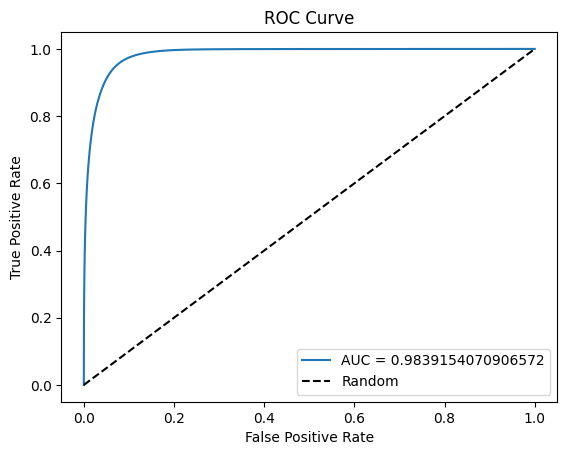

In [19]:
# Caclulate false positive rate and true positive rate
true = []
pred = []
with torch.no_grad():
    for img, mask in test_loader:
        output = model(img)
        true.extend(mask.numpy().flatten())
        pred.extend(output[:, 1].numpy().flatten())

# Sort ROC curve so that fpr is increasing
fpr, tpr, _ = roc_curve(true, pred)
auc = roc_auc_score(true, pred)

# Plot ROC curve
fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()

The above code shows a simple implementation of plotting and calculating the ROC curve and AUC score. Notice that in the `testing.py` function, we add some complexity to handle large datasets by randomly subsampling the data after evaluation. This is because calculating the ROC curve and AUC score can be computationally expensive for large datasets.

## Conclusion

In this tutorial, we learned how to evaluate models in PyTorch using the `torch` and `torch.nn` modules. We also learned how to calculate the Accuracy, Specificity, Sensitivity, ROC curve, and AUC score. These metrics are crucial for evaluating the performance of our models and selecting the best model for our specific task.